# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
pd.set_option('display.max_columns', 500)

In [3]:
# peek into the dataset
data[['firstname', 'education', 'yearsexp', 'race', 'call']][::1000]

,firstname,education,yearsexp,race,call
0,Allison,4,6,w,0.0
1000,Brett,4,6,w,0.0
2000,Tanisha,4,2,b,0.0
3000,Greg,4,26,w,0.0
4000,Carrie,4,6,w,0.0


<div class="span5 alert alert-success">
<p>1. What test is appropriate for this problem? Does CLT apply?
What are the null and alternate hypotheses?</p>
</div>


We are comparing two sample proportions. Both are random samples and the sample sizes are less than 10% of the workforce. Let's exmaple the third condition if it meets the CLT requirements, as follows,

In [4]:
w = data[data.race=='w']
b = data[data.race=='b']

In [5]:
# callback rate for white
p1 = w['call'].sum() / len(w)
n1 = len(w)

# callback rate for black
p2 = b['call'].sum() / len(b)
n2 = len(b)

result = (n1*p1 >= 10) & (n1*(1-p1) >= 10) & (n2*p2 >= 10) & (n2*(1-p2) >= 10)

print('Does it satisfy the CLT requiremen?')

if result:
    print('Yes!')
else:
    print('No!')

Does it satisfy the CLT requiremen?
Yes!


Since the samples meet CLT requirements, we can use z-test. The null hypothesis is:

- H0: There is no racial discrimination, ie, the call-back rate is the same for white and black or p1 = p2.
- Ha: There exists racial discrimination, i.e., the call-back rate is different or p1 != p2.

<div class="span5 alert alert-success">
<p>2. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.</p>
</div>



### 2.2 Frequentist statistical approach

In [6]:
p_w_callback = w['call'].sum() / len(w)

p_b_callback = b['call'].sum() / len(b)

print('callback rate for white:', p_w_callback) 
print('callback rate for black:', p_b_callback)

callback rate for white: 0.0965092402464
callback rate for black: 0.064476386037


In [7]:
def two_sample_proportion(p1, p2):
    diff = p1 - p2
    q1 = 1 - p1
    q2 = 1 - p2
    p = (w['call'].sum() + b['call'].sum()) / (len(w) + len(b))
    q = 1 - p
    std = np.sqrt(p * q * (1 / len(w) + 1 / len(b)))
    z = abs((p1 - p2) / std)
    p_value = stats.norm.cdf(-z)
    moe = 1.96 * std # 95% confidence
    ci = [diff - moe, diff + moe]
    return z, p_value, moe, ci

z, p_value, moe, ci = two_sample_proportion(p_w_callback, p_b_callback)
print('z_score:', z)
print('p_value:', p_value)
print('margin of error at 95% confidence:', moe)
print('95% confidence interval:', ci)

z_score: 4.10841215243
p_value: 1.99194341879e-05
margin of error at 95% confidence: 0.0152819123109
95% confidence interval: [0.016750941898551489, 0.047314766520339682]


p-value is about 2e-5 that is much less than 0.05. We can confidently reject the null hypothesis. 

In [8]:
w[['firstname', 'education', 'yearsexp', 'race', 'call']].head()

,firstname,education,yearsexp,race,call
0,Allison,4,6,w,0.0
1,Kristen,3,6,w,0.0
4,Carrie,3,22,w,0.0
5,Jay,4,6,w,0.0
6,Jill,4,5,w,0.0


### 2.2 Bootstrapping approach

In [9]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff(data1, data2):
    return data1.sum() / len(data1) - data2.sum() / len(data2)

sample_diff:  0.0320328542094
p-value: 0.0


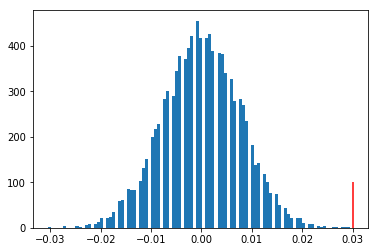

In [10]:
# calculate sample proportion of difference
sample_diff = diff(w['call'], b['call'])
print('sample_diff: ', sample_diff)

# draw permutation replicates of difference in mean
perm_replicates = draw_perm_reps(w['call'], b['call'], diff, size=10000)

p_value = np.sum(perm_replicates >= sample_diff) / len(perm_replicates)

print('p-value:', p_value)

plt.hist(perm_replicates, bins=100)
plt.vlines(0.03, 0, 100, color='red')
plt.show()

p-value is zero, suggesting the callback rate for whites and blacks are indeed different.

<div class="span5 alert alert-success">
<p> Write a story describing the statistical significance in the context or the original problem.
Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis? </p>
</div>

## 3. Discussion

Both z-test and bootstrapping approaches conclude that the call back rate is significantly different for whites and blacks. However, other factors like education, experience, et al, that are linked to race may also contribute to the call back rate. The correlation is not a determinant for drawing final conclusion. 